<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Heterogeneity Metrics

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy* [e-book]. Zenodo. doi:10.5281/zenodo.15169133 [![DOI](https://zenodo.org/badge/838927017.svg)](https://doi.org/10.5281/zenodo.15169132)  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository* (0.0.1) [Software]. Zenodo. doi:10.5281/zenodo.12667036. GitHub Repository: https://github.com/GeostatsGuy/GeostatsPyDemos [![DOI](https://zenodo.org/badge/777871341.svg)](https://doi.org/10.5281/zenodo.12667035)



```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Heterogeneity Metrics**. 

**YouTube Lecture**: check out my lecture on:

* [Heterogeneity Metrics](https://youtu.be/PG4fn8NPFGA?si=oQrgRmG6DXfHW-41)

These lectures are all part of my [Data Analytics and Geostatistics Course](https://www.youtube.com/playlist?list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ) on YouTube with linked well-documented Python workflows and interactive dashboards. My goal is to share accessible, actionable, and repeatable educational content. If you want to know about my motivation, check out [Michael's Story](https://michaelpyrcz.com/my-story). 

#### Motivation

There is a vast difference in heterogeneity of reservoirs,

* heterogeneity is the change in features over location or time

* conversely, homogeneity is the consistency of variables over location or time 

Heterogeneity impacts the recovery of hydrocarbons from the reservoir, minerals from ore bodies and water from aquifers,

* we need metrics to quantify the heterogeneity in our subsurface data and subsurface models 




##### Applications with Measures of Heterogeneity

* Measures of heterogeneity are often applied proxy, approximate measures to indicate reservoir production / performance.  
* These measures may be applied to compare and rank reservoirs or reservoir model realizations for a single reservoir.  

##### Best Practice

* None of these metrics are perfect.  

* The best result possible from rigorous flow forecasting applied to good, full 3D reservoir models, use the physics when possible!

* Integrate all relevant information, at sufficient scale to resolve important features

###### Caution

* Use of simple heterogeneity measures for ranking reservoir and reservoir models can be dangerous.  

* Inaccuracy can result in incorrect rank estimates; therefore, incorrect business decisions.

###### Other Measures

* We just consider simple, static measures here

* I also have a Python demonstration for [Lorenz coefficient](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Lorenz_coefficient_demo.ipynb)

* Got your own measure?  You may develop a new metric. Novel methods for quantifying heterogeneity within reservoirs is a currently active area of research.

#### Load the Required Libraries

The following code loads the required libraries.

In [1]:
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # arrays
import pandas as pd                                           # dataframes
import scipy.stats as stats                                   # statistical functions
from scipy.integrate import quad                              # for numerical integration
import math                                                   # square root to calculate standard deviation from variance
import matplotlib.pyplot as plt                               # plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import matplotlib.ticker as mtick                             # control tick label formatting
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
seed = 42                                                     # random number seed

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.

#### Define Functions

This is a convenience function to add major and minor gridlines to improve plot interpretability.

In [2]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [3]:
#os.chdir("c:/PGE383/Examples")             # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.

* we will use this spatial dataset for our heterogeneity metrics up to Lorenz coefficient, for this Lorenz coefficient load a single well with porosity and permeability features

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/PorPermSample1.csv')
df.head()

,Depth,Porosity,Perm
0,0.25,12.993634,265.528738
1,0.50,13.588011,116.891220
2,0.75,8.962625,136.920016
3,1.00,17.634879,216.668629
4,1.25,9.424404,131.594114


#### Feature Engineering

We will need to make a new feature, approximate rock quality index, the ratio of permeability divided by porosity.

* rock quality index (RQI) approximation - the formula for calculating RQI includes permeability divided by porosity and is commonly used to identify rock groups, like facies. While we only use the permeability divided by porosity ratio, the complete equation for RQI is,

$$
RQI = 0.0314 \times \sqrt{\frac{k}{\phi}}
$$

In [5]:
df['PermPor'] = df['Perm'].values/df['Porosity'].values       # new feature as permability divided by porosity
df.head()

,Depth,Porosity,Perm,PermPor
0,0.25,12.993634,265.528738,20.435295
1,0.50,13.588011,116.891220,8.602526
2,0.75,8.962625,136.920016,15.276776
3,1.00,17.634879,216.668629,12.286369
4,1.25,9.424404,131.594114,13.963124


#### Variance of Permeability

It is common to use the sample or population variance of permeability as a measure of heterogeneity. I demonstrate the sample variance. 

\begin{equation}
\sigma_{X_k}^2 = \frac{1}{n} \sum_{i=1}^{n-1} (x_{k,i} - \overline{x_k})^2
\end{equation}

In [6]:
var_perm = np.var(df['Perm'].values,ddof=1)                   # sample variance of permeability 
print('Sample Variance of Permeability: ' + str(np.round(var_perm,2)) + ' mD^2')

Sample Variance of Permeability: 6544.83 mD^2


#### Coefficient of Variation of Permeability

Another common heternogeneity metric is the coefficient of variation, the standard deviation standardized by the mean.

\begin{equation}
C_{v_k} = \frac{\sigma_k}{\overline{k} }
\end{equation}

Note, by specifying the ddof arguement of 1, we are using the sample standard deviation in the calculation.

In [7]:
coefvar_perm = stats.variation(df['Perm'].values,ddof=1)      # coefficient of variation of permeability
print('Coefficeint of Variation of Permeability: ' + str(np.round(coefvar_perm,3)) + ' unitless')

Coefficeint of Variation of Permeability: 0.502 unitless


#### Coefficient of Variation of Permeability / Porosity

Also it is common to calculate the coefficient of variation of the ratio of permeability divided by porosity.

\begin{equation}
C_{v_\frac{k}{\phi}} = \frac{\sigma_{\frac{k}{\phi}}}{\overline{\frac{k}{\phi}} }
\end{equation}

In [8]:
coefvar_permpor = stats.variation(df['PermPor'].values,ddof=1) # coefficient of variation of permeability divided by porosity
print('Coefficient of Variation of Permeability / Porosity: ' + str(np.round(coefvar_permpor,3)) + ' unitless')

Coefficient of Variation of Permeability / Porosity: 0.369 unitless


#### Dykstra Parsons

Now let's calculate the Dykstra-Parsons coefficient. 

\begin{equation}
DP = \frac{P50_k - P16_k}{P50_k}
\end{equation}

In [9]:
P16_perm = np.percentile(df['Perm'].values,16)                # the permeability 16th percentile
P50_perm = np.percentile(df['Perm'].values,50)                # the permeability 50th percentile (median)

print('Permeability P16: ' + str(np.round(P16_perm,3)))
print('Permeability P50: ' + str(np.round(P50_perm,3)))

dp = (P50_perm - P16_perm)/P50_perm                           # Dykstra Parsons
print('\nDykstra-Parsons Coefficient: ' + str(np.round(dp,3)) + ' unitless')

Permeability P16: 84.797
Permeability P50: 144.33

Dykstra-Parsons Coefficient: 0.412 unitless


#### Dykstra-Parsons Improved by Fitting a Lognormal Distribution to Permeability

We may be able to improve our Dykstra-Parsons coefficient calculation by fitting a lognormal distibution to permeability and then using the parametric lognormal distribution to get a more accurate estimate of the P50 and P16 or permeability.

1. calculate the lognormal parameters, \mu (mu) and \sigma (sigma)
2. use the parametric lognormal CDF inverse to get the P50 and P16

In [10]:
mean_perm = np.average(df['Perm'].values)                     # average of permeability

mu = np.log((mean_perm**2)/math.sqrt(var_perm + mean_perm**2)) # given the average and variance, calculate the associated lognormal mu and sigma
sigma = math.sqrt(np.log(var_perm/(mean_perm**2)+1))

print('Lognormal distribution parameters are, mu: ' + str(np.round(mu,2)) + ', and sigma: ' + str(np.round(sigma,2)))

Lognormal distribution parameters are, mu: 4.97, and sigma: 0.47


Now we can calculate the P50 and P16 of permeability from the fit lognormal distribution.

* Note, we could have been more rigorous with our distribution fit with a ordinary least squares or maximum likelihood approach.

In [11]:
P16_perm_lognorm = stats.lognorm.ppf(0.16,s = sigma, scale = math.exp(mu)) # calculate permeability P16 and P50 from our estimated lognormal distribution
P50_perm_lognorm = stats.lognorm.ppf(0.50,s = sigma, scale = math.exp(mu))

print('Permeability P16 from Lognormal Parametric Distribution: ' + str(np.round(P16_perm_lognorm,3)))
print('Permeability P50 from Lognormal Parametric Distribution: ' + str(np.round(P50_perm_lognorm,3)))

Permeability P16 from Lognormal Parametric Distribution: 89.754
Permeability P50 from Lognormal Parametric Distribution: 143.869


In [12]:
dp_lognorm = (P50_perm_lognorm - P16_perm_lognorm)/P50_perm_lognorm # Dykstra-Parsons coefficient
print('\nDykstra-Parsons Coefficient: ' + str(np.round(dp_lognorm,3)) + ' unitless')


Dykstra-Parsons Coefficient: 0.376 unitless


#### Visualize the Lognormal Permeability Parametric Distribution

Let's check our lognormal parametric distribution fit.

* we visualize the lognormal parametric CDF and the permeability data nonparametric distribution together to check the fit

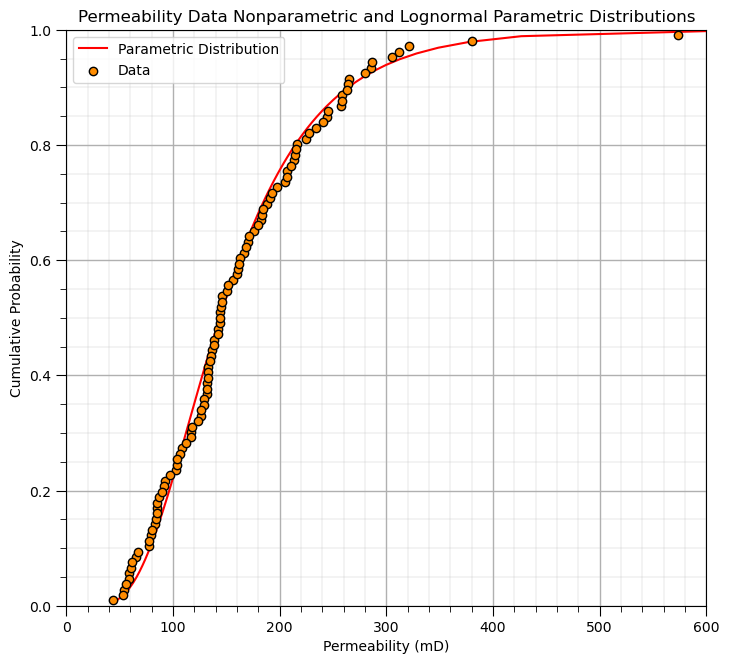

In [13]:
cumul_prob = np.linspace(0.01,0.999,100)                      # get points on our estimated lognormal distribution
lognormal = stats.lognorm.ppf(cumul_prob,s = sigma, scale = math.exp(mu))

plt.plot(lognormal,cumul_prob,color='red',label='Parametric Distribution',zorder=1)
plt.xlabel('Permeability (mD)'); plt.ylabel('Cumulative Probability'); plt.title('Permeability Data Nonparametric and Lognormal Parametric Distributions')
plt.ylim([0,1]); plt.xlim([0,600]); plt.grid()
plt.scatter(df['Perm'].values,df["Perm"].rank()/(len(df)+1),color='darkorange',edgecolor='black',zorder=10,label='Data')
plt.legend(loc='upper left'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.4); plt.show()

#### Load a Single Well 

For the Lorenz coefficient we work with the statistics of stacked stratigraphic units in a single well. 

* we could sumarize the Lorenz coefficient over many wells but this would require a more complicated geological modeling workflow.

Number of samples in the well = 105


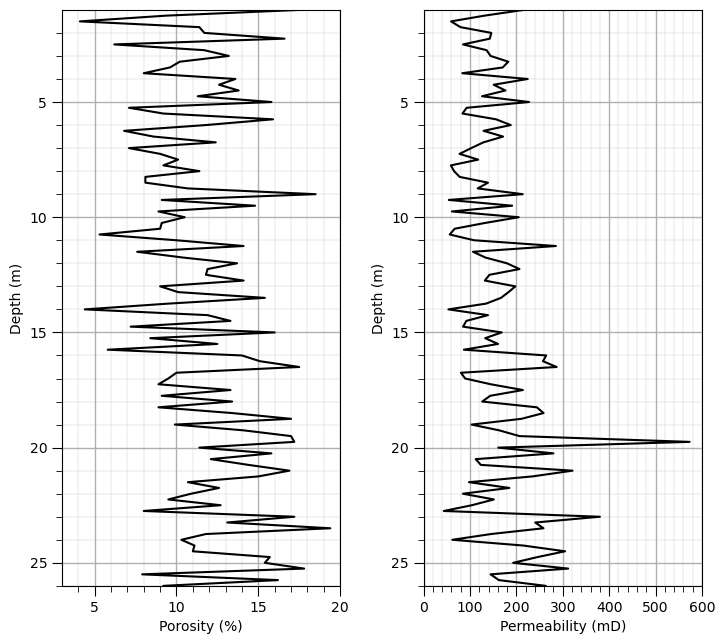

In [14]:
df_well = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/WellPorPermSample_3.csv') 
df_well = df_well.rename(columns={"Depth (m)":"Depth", "Por (%)":"Por", "Perm (mD)":"Perm"})
nwell = len(df_well)
print('Number of samples in the well = ' + str(nwell))

plt.subplot(121)
plt.plot(df_well['Por'],df_well['Depth'],color='black'); add_grid(); plt.xlabel('Porosity (%)'); plt.ylabel('Depth (m)')
plt.ylim([26,1]); plt.xlim([3,20])

plt.subplot(122)
plt.plot(df_well['Perm'],df_well['Depth'],color='black'); add_grid(); plt.xlabel('Permeability (mD)'); plt.ylabel('Depth (m)')
plt.ylim([26,1]); plt.xlim([0,600])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.4); plt.show()

#### Lorenz Coefficient Method

##### 1. Feature Engineering

To prepare for the calculation of Lorenz Coefficient we need,

* thickness - the thickness of eacch unit, in this case we observed equal thickness units at 0.25 m

* rock quality index (RQI) approximation - once again we approximate RQI with only the ratio of permeability divided by porosity. For our application here we only need to sort the rock in descending rock quality index, so the square root and constant term would not change this order.

$\quad$ since the square root and constant do not impact the order after sorting (below) we leave them out for brevity.

In [15]:
df_well['Thick'] = np.full(len(df_well),0.25)
df_well['PermPor'] = df_well['Perm']/df_well['Por']
df_well.head()

,Depth,Por,Perm,Thick,PermPor
0,0.25,13.0,265.5,0.25,20.423077
1,0.50,13.6,116.9,0.25,8.595588
2,0.75,9.0,136.9,0.25,15.211111
3,1.00,17.6,216.7,0.25,12.312500
4,1.25,9.4,131.6,0.25,14.000000


##### 2. Sort the Data in Descending 

In [16]:
df_well = df_well.sort_values('PermPor',ascending = False)                   # sort in descending order
df_well.head()

,Depth,Por,Perm,Thick,PermPor
78,19.75,17.2,573.5,0.25,33.343023
103,26.00,9.2,263.5,0.25,28.641304
97,24.50,11.0,305.1,0.25,27.736364
72,18.25,8.9,244.1,0.25,27.426966
91,23.00,17.2,380.1,0.25,22.098837


##### 3. Calculate Storage and Flow Capacities

We calculate these as, storage capacity (SC),

$$
\text{SC} = \phi \times \text{Th}
$$

and flow capacity (FC),

$$
\text{FC} = k \times \text{Th}
$$

In [17]:
df_well['Storage'] = df_well['Por'] * df_well['Thick']
df_well['Flow'] = df_well['Perm'] * df_well['Thick']
df_well.head()

,Depth,Por,Perm,Thick,PermPor,Storage,Flow
78,19.75,17.2,573.5,0.25,33.343023,4.300,143.375
103,26.00,9.2,263.5,0.25,28.641304,2.300,65.875
97,24.50,11.0,305.1,0.25,27.736364,2.750,76.275
72,18.25,8.9,244.1,0.25,27.426966,2.225,61.025
91,23.00,17.2,380.1,0.25,22.098837,4.300,95.025


##### 4. Calculate the Cumulative Storage and Flow Capacities

We apply the cummulative sum down each column, storage capacity and flow capacity.

In [18]:
df_well['Storage_Cumul'] = df_well['Storage'].cumsum()
df_well['Flow_Cumul'] = df_well['Flow'].cumsum()
df_well.head()

,Depth,Por,Perm,Thick,PermPor,Storage,Flow,Storage_Cumul,Flow_Cumul
78,19.75,17.2,573.5,0.25,33.343023,4.300,143.375,4.300,143.375
103,26.00,9.2,263.5,0.25,28.641304,2.300,65.875,6.600,209.250
97,24.50,11.0,305.1,0.25,27.736364,2.750,76.275,9.350,285.525
72,18.25,8.9,244.1,0.25,27.426966,2.225,61.025,11.575,346.550
91,23.00,17.2,380.1,0.25,22.098837,4.300,95.025,15.875,441.575


##### 5. Calculate the Cumulative Fraction of Storage and Flow Capacities

We divide the storage and flow capacities by the largest value, i.e., the value in the last row, so that our statistics represent the fraction of the total cumulative.

In [19]:
df_well['Storage_Cumul_Frac'] = df_well['Storage_Cumul'] / df_well['Storage_Cumul'].max()
df_well['Flow_Cumul_Frac'] = df_well['Flow_Cumul'] / df_well['Flow_Cumul'].max()
df_well.head()

,Depth,Por,Perm,Thick,PermPor,Storage,Flow,Storage_Cumul,Flow_Cumul,Storage_Cumul_Frac,Flow_Cumul_Frac
78,19.75,17.2,573.5,0.25,33.343023,4.300,143.375,4.300,143.375,0.014024,0.033922
103,26.00,9.2,263.5,0.25,28.641304,2.300,65.875,6.600,209.250,0.021525,0.049508
97,24.50,11.0,305.1,0.25,27.736364,2.750,76.275,9.350,285.525,0.030493,0.067555
72,18.25,8.9,244.1,0.25,27.426966,2.225,61.025,11.575,346.550,0.037750,0.081994
91,23.00,17.2,380.1,0.25,22.098837,4.300,95.025,15.875,441.575,0.051773,0.104476


##### 6. Calculate the Lorenz Coefficient

This code may look a bit complicated, but the steps are simply,

1. **Lorez Curve Model** - fit a ploynomial (3rd order is sufficient) to the experimental Lorenz curve points
2. **Lorenz Area** - integrate between the fit polynomial curve and the homogeneous $Y = X$ line
3. **Lorenz Coefficient** - divide by 0.5 to get the ratio of the Lorenz area divided by the total area above the homogeneous line

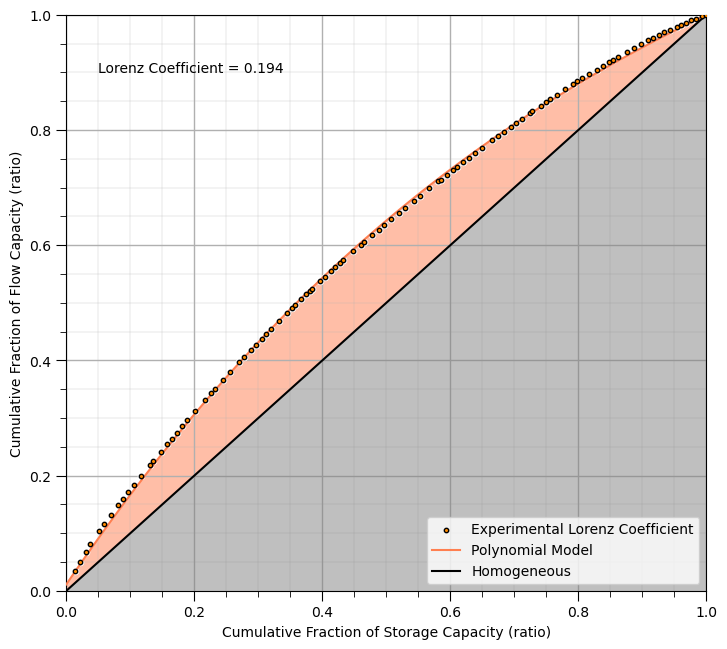

In [20]:
weights = np.ones(nwell)                                     
weights[0] = 1000; weights[-1] = 1000                 # to ensure the fit converges to (0,0) and (1,1)
    
coeffs = np.polyfit(df_well['Storage_Cumul_Frac'],df_well['Flow_Cumul_Frac'], deg=3, w=weights)
poly_fit = np.poly1d(coeffs)                          # create a polynomial function from the coefficients

def diff(x):
    return poly_fit(x) - x

lorenz_area, _ = quad(diff, a=0.0, b=1.0)

LC = np.round(lorenz_area/0.5,3)

plt.scatter(df_well['Storage_Cumul_Frac'],df_well['Flow_Cumul_Frac'],s=10,color='darkorange',edgecolor='black',label='Experimental Lorenz Coefficient',zorder=10)
plt.scatter(df_well['Storage_Cumul_Frac'],df_well['Flow_Cumul_Frac'],s=20,color='white',zorder=1)

plt.plot(np.linspace(0,1,100), poly_fit(np.linspace(0,1,100)),color='coral',zorder=5,label = 'Polynomial Model')

plt.annotate('Lorenz Coefficient = ' + str(LC),[0.05,0.9])

plt.fill_between(np.linspace(0,1,100), np.linspace(0,1,100),np.zeros(100), alpha = 0.5,facecolor='gray') 

plt.fill_between(np.linspace(0,1,100), poly_fit(np.linspace(0,1,100)),
                 np.linspace(0,1,100), alpha = 0.5,facecolor='coral',zorder=0) 

plt.xlim([0,1]); plt.ylim([0,1]); plt.xlabel('Cumulative Fraction of Storage Capacity (ratio)'); plt.ylabel('Cumulative Fraction of Flow Capacity (ratio)')
add_grid(); plt.plot([0,1],[0,1],color='black',label='Homogeneous'); plt.legend(loc='lower right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.4); plt.show()

#### Comments

This is a simple distribution of heterogeneity metrics. Much more could be done and discussed, I have many more resources. Check out my [shared resource inventory](https://michaelpyrcz.com/my-resources) and the YouTube lecture links at the start of this chapter with resource links in the videos' descriptions.

I hope this is helpful,

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
